#### Import / Global Vars

In [30]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [31]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [54]:
# Global variables
log = True
refresh_pricing = False
universe = 'spy-sectors' # 'spy_sectors OR 'ark_etfs'
active_etf = None # ETF name OR None for broad market
#variables for performance analysis
frequency = "W-THU" # initial value for lookback
lb = 60; min_gross=0.5; max_gross=1; min_w=0; max_w=0.05 # default optimization vars

#### Load sector components from hard-drive

In [55]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (1010, 3)
Loaded pricing for spy-sectors.csv, with shape (69, 10)
Loaded pricing for SPY.csv, with shape (69, 1)


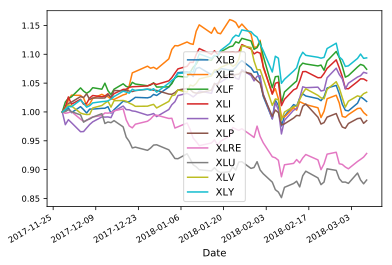

In [56]:
# plots key elements of the universe selected
compound(px_etfs).plot(fontsize='small') # exclude from long strat the negative sectors?

#### Get Data from the Server

In [57]:
# New approach using dynamic key lookup name
if refresh_pricing:
    etfs = [e for e in ticker_map[universe]]
    refresh_components(etfs)
    get_safe_pricing(universe + '.csv', ticker_map[universe], start_date)
    get_safe_pricing('SPY.csv', ['SPY'], start_date)
    px_etfs = load_pricing(universe + '.csv', 'Date')
    px_spy = load_pricing('SPY.csv', 'Date')

In [58]:
# Load pricing for components of each sectors
consol_px = clean_nas(load_consol_px(ticker_map, universe))
if(active_etf != None): companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
tickers=[i for i in tickers if i not in ['BF.b','BRK.b']] ## esta es una correcion extra para no incluir 'BF.b','BRK.b'
consol_px = consol_px[list(set(tickers))]

Loaded pricing for XLE-hold-pricing.csv, with shape (69, 32)
Loaded pricing for XLU-hold-pricing.csv, with shape (69, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (69, 71)
Loaded pricing for XLB-hold-pricing.csv, with shape (69, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (69, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (69, 84)
Loaded pricing for XLI-hold-pricing.csv, with shape (69, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (69, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (69, 67)
Loaded pricing for XLRE-hold-pricing.csv, with shape (69, 33)


In [59]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA', 'DISCK', 'JUNO', 'XL', 'WELL', 'BKNG', 'SNI'] # example: two M&A targets, diff share classes...
remove = list(set(remove_tickers).intersection(consol_px.columns.tolist()))
if len(remove) > 0:
    consol_px.drop(remove, axis=1, inplace=True)

In [60]:
# OLD MVO functions
# Mean variance optimization
def get_mean_variance(rets):
    w_len = rets.shape[1] # number of columns
    eq_weights = np.asarray([1/w_len for _ in range(w_len)]) #default weights
    mu = rets.mean()
    std_dev = rets.std()
    cov_matrix = rets.cov()
    return w_len, eq_weights, mu.values, std_dev, cov_matrix.values
def get_weights(px, freq, lb, min_sum, max_sum, min_w, max_w, gamma):
    px = clean_nas(px)
    returns = px.sort_index().pct_change(); returns.iloc[0] = 0
    intervals = pd.to_datetime(date_intervals(returns, freq).index.tolist())
    valid_dates = [d for d in intervals if d in returns.index]    
    hist_alloc = pd.DataFrame(np.zeros((returns.shape)), index=returns.index, columns=returns.columns)
    for i in valid_dates:
        lb_returns = returns.loc[:i.date()].tail(lb).dropna()
        weights = np.array([0 for _ in range(len(returns.columns))])
        if (len(lb_returns) > 2):
            n, weights, mu_ret, std_dev, cov_mtrx = get_mean_variance(lb_returns)
            weights = get_mvo_allocations(
                n, mu_ret, cov_mtrx, min_sum, max_sum, min_w, max_w, gamma)
        hist_alloc.loc[i.date()] = weights
    hist_alloc = hist_alloc.loc[returns.index].replace(0, np.nan).fillna(method='ffill')
    hist_alloc.replace(np.nan, 0, inplace=True)
    return returns, hist_alloc
def get_mvo_allocations(n, mu_ret, cov_mtrx, min_sum, max_sum, min_w, max_w, gamma_val):
    mu = mu_ret.T
    Sigma = cov_mtrx
    w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    ret = mu.T * w 
    risk = cvx.quad_form(w, Sigma)
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
        [cvx.sum_entries(w) >= min_sum, cvx.sum_entries(w) <= max_sum, 
         w > min_w, w < max_w])
    gamma.value = gamma_val
    prob.solve()
    if prob.status == 'optimal': 
        return [i[0] for i in w.value.tolist()]
def recommend_allocs(px, frame, lb, freq, min_sum, max_sum, min_w, max_w, gamma):
    px = clean_nas(px)
    px_portion = px[-abs(frame):].copy() 
    returns, alloc = get_weights(
        px_portion, freq, lb, min_sum, max_sum, min_w, max_w, gamma)
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["M2-cvxopt"])
    return px_portion, returns, alloc, pdf

In [61]:
# return portfolio sharpe for a given optimization
def get_sr_for_opt(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, gamma):
    px_p, _, alloc, pdf = recommend_allocs(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, gamma)
    rec = last_allocation(alloc, 0.01)
    ret, risk = port_metrics(px_p, rec)
    return ret / risk

# pending implementation using partials
def quick_gamma(glist, c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w):
    if len(glist) <= 1: 
        mid_g = glist[0]
        mid_sr = get_sr_for_opt(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, mid_g)
        return mid_g, mid_sr
    else:
        mid = len(glist)//2; left = glist[:mid]; right = glist[mid:]
        mid_l = left[len(left)//2]; mid_r = right[len(right)//2]
        left_sr = get_sr_for_opt(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, mid_l)
        right_sr = get_sr_for_opt(c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w, mid_r)
        if left_sr > right_sr: sublist = left
        else: sublist = right
        return quick_gamma(sublist, c_px, t_w, lb, f, mi_g, ma_g, mi_w, ma_w)

In [62]:
# range of potential gammas using logspace
SAMPLES = 100; gamma_vals = np.logspace(-2, 3, num=SAMPLES)
gamma_val, gamma_sr = quick_gamma(gamma_vals, consol_px, hist_window, lb, frequency, min_gross, max_gross, min_w, max_w)
gamma_val, gamma_sr

(54.62277217684343, 3.4379700728975435)

In [63]:
mini_px = consol_px[consol_px.columns[:10]].tail(5) # pricing subset
as_of = consol_px.index.to_datetime()[-1:] # date as of when we want the weights vector

print(mini_px.shape, frame, lb, frequency, min_gross, max_gross, min_w, max_w, gamma_val)
mini_px.shape, as_of

(5, 10) 20 60 W-THU 0.5 1 0 0.05 54.62277217684343


((5, 10),
 DatetimeIndex(['2018-03-08'], dtype='datetime64[ns]', name='Date', freq=None))

In [64]:
lb_returns, lb_weights = get_weights(mini_px, frequency, lb, min_gross, max_gross, min_w, max_w, gamma_val)

print("returns shape:", lb_returns.shape, "lookback:", lb)
print("weights shape:", lb_weights.shape, "sum weights:", lb_weights[-1:].sum(axis=1).tolist()[0], 
      "min gross:", min_gross, "max gross:", max_gross)

# old recommend allocations
old_px_portion, old_returns, old_alloc, old_pdf = recommend_allocs(
    mini_px, frame, lb, frequency, min_gross, max_gross, min_w, max_w, gamma_val)

old_alloc.shape, old_alloc[-1:].values

returns shape: (5, 10) lookback: 60
weights shape: (5, 10) sum weights: 0.4999999999859775 min gross: 0.5 max gross: 1


((5, 10),
 array([[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]]))

In [65]:
# New cleaned MVO functions
# Mean variance optimization
def get_mean_variance(rets):
    w_len = rets.shape[1] # number of columns
    eq_weights = np.asarray([1/w_len for _ in range(w_len)]) #default weights
    mu = rets.mean(); std_dev = rets.std(); cov_matrix = rets.cov()
    return w_len, eq_weights, mu.values, std_dev, cov_matrix.values
def get_mvo_allocations(n, mu_ret, cov_mtrx, min_sum, max_sum, min_w, max_w, gamma_val):
    mu = mu_ret.T; Sigma = cov_mtrx; w = cvx.Variable(n)
    gamma = cvx.Parameter(sign='positive')
    ret = mu.T * w; risk = cvx.quad_form(w, Sigma)
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
        [cvx.sum_entries(w) >= min_sum, cvx.sum_entries(w) <= max_sum, 
         w > min_w, w < max_w])
    gamma.value = gamma_val; prob.solve()
    if prob.status == 'optimal': return w.value
def get_weights(px, asof, lb, min_sum, max_sum, min_w, max_w, gamma):
    lb_rets = px.sort_index().pct_change().dropna().tail(lb) # capture the last lb days going back
    # the below line make the old and new version return the same results, new implementation is more accurate
    # lb_rets = px.sort_index().pct_change(); lb_rets.iloc[0] = 0
    n, weights, mu_ret, std_dev, cov_mtrx = get_mean_variance(lb_rets)
    np_weights = np.array(get_mvo_allocations(n, mu_ret, cov_mtrx, min_sum, max_sum, min_w, max_w, gamma))
    lb_weights = pd.DataFrame(np_weights.T, index=[as_of], columns=lb_rets.columns)
    return lb_rets, lb_weights
def recommend_allocs(px, frame, lb, asof, min_sum, max_sum, min_w, max_w, gamma):
    px = clean_nas(px); px_portion = px[-frame:].copy()
    returns, alloc = get_weights(px_portion, asof, lb, min_sum, max_sum, min_w, max_w, gamma)
    port_perf = calc_port_performance(returns.values, alloc.values)
    pdf = pd.DataFrame(port_perf, index=returns.index, columns=["M2-cvxopt"])
    return px_portion, returns, alloc, pdf

In [66]:
# get new last weights
lb_returns, lb_weights = get_weights(mini_px, as_of, lb, min_gross, max_gross, min_w, max_w, gamma_val)

print("returns shape:", lb_returns.shape, "lookback:", lb)
print("weights shape:", lb_weights.shape, "sum weights:", lb_weights.sum(axis=1).tolist()[0], 
      "min gross:", min_gross, "max gross:", max_gross)

# new recommend allocations
new_px_portion, new_returns, new_alloc, new_pdf = recommend_allocs(
    mini_px, frame, lb, as_of, min_gross, max_gross, min_w, max_w, gamma_val)

# print both weight vectors, they should be the same
new_alloc.shape, new_alloc[-1:].values

returns shape: (4, 10) lookback: 60
weights shape: (1, 10) sum weights: 0.4999999999710926 min gross: 0.5 max gross: 1


((1, 10),
 array([[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]]))

In [67]:
# old port metric
def port_metrics(px, rec):
    # this is supposed to be the righ way to calculate the portfolio risk
    px.sort_index(inplace=True)
    returns = px[rec.index.tolist()].pct_change()
    mean_daily_returns = returns.mean()
    cov_matrix = returns.cov()
    weights = np.asarray(rec.values)
    mult = len(mean_daily_returns)
    port_return = np.dot(mean_daily_returns.values, weights) * mult
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights))) * np.sqrt(mult)
    return port_return[0], port_risk[0][0]

rec = last_allocation(new_alloc, 0.01)
ret, risk = port_metrics(new_px_portion, rec)
ret, risk, ret / risk

(0.025780253122188915, 0.012119980923153565, 2.1270869389686307)

In [68]:
# new port metrics
def port_metrics(px, rec):
    # this is supposed to be the righ way to calculate the portfolio risk
    px.sort_index(inplace=True)
    returns = px[rec.index.tolist()].pct_change().dropna()
    mean_daily_returns = returns.mean()
    cov_matrix = returns.cov()
    weights = np.asarray(rec.values)
    mult = len(returns.index)
    port_return = np.dot(mean_daily_returns.values, weights) * mult
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights))) * np.sqrt(mult)
    return port_return[0], port_risk[0][0]

rec = last_allocation(new_alloc, 0.01)
ret, risk = port_metrics(new_px_portion, rec)
ret, risk, ret / risk

(0.010312101248875567, 0.007665348982991089, 1.3452879016672885)

#### Generate Trading Recomendations

In [69]:
print("Gamma: {0:.2f}, Lookback: {1}, Max Weight: {2}".format(gamma_val, lb, max_w))

Gamma: 54.62, Lookback: 60, Max Weight: 0.05


In [70]:
# run optimization with best gamma, returns initial weights
px_portion, returns, alloc, pdf = recommend_allocs(
    consol_px, hist_window, lb, frequency, min_gross, max_gross, min_w, max_w, gamma_val)
rec = last_allocation(alloc, 0.01)
tickers = rec.index.tolist()
recommend = rec.copy()
cos_no_dup = companies.drop_duplicates(subset='Company')
recommend['Sector'] = cos_no_dup.loc[tickers]['ETF']
recommend['Company'] = cos_no_dup.loc[tickers][['Company']]
recommend = recommend.astype({"Allocation": np.float})
recommend[['Company', 'Sector', 'Allocation']]
recommend

,Allocation,Sector,Company
STX,0.050000,XLK,Seagate Technology
MSI,0.036786,XLK,Motorola Solutions Inc
WYNN,0.031269,XLY,Wynn Resorts Ltd
CHD,0.029124,XLP,Church & Dwight Co
QRVO,0.019273,XLK,"Qorvo, Inc"
AKAM,0.021749,XLK,Akamai Technologies Inc
EL,0.050000,XLP,Estee Lauder Cos. A
GWW,0.016087,XLI,Grainger W.W. Inc
AMZN,0.050000,XLY,Amazon.com Inc
EA,0.016590,XLK,Electronic Arts


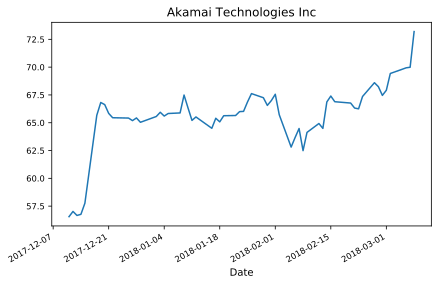

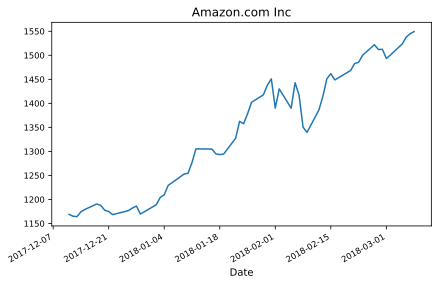

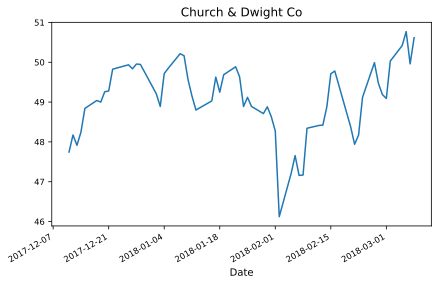

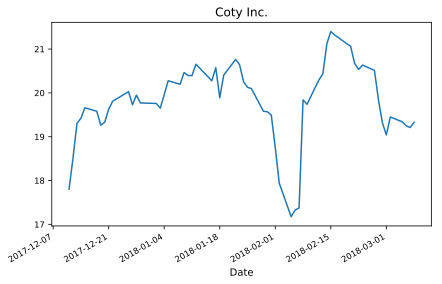

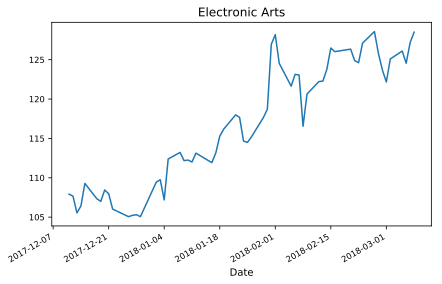

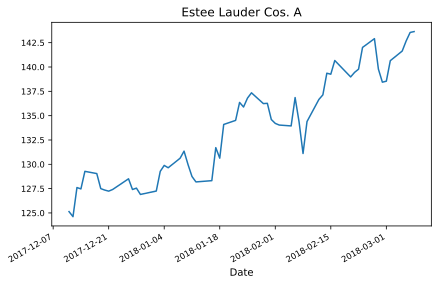

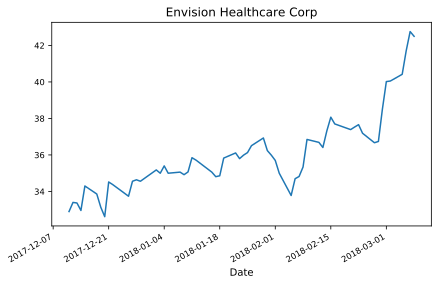

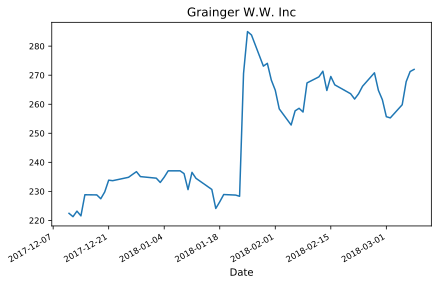

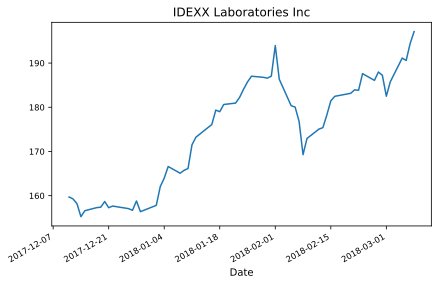

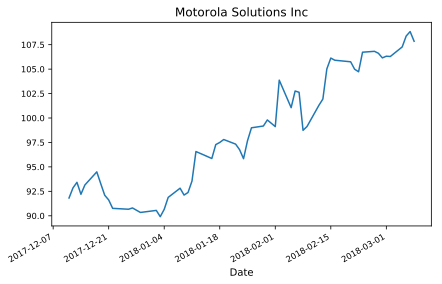

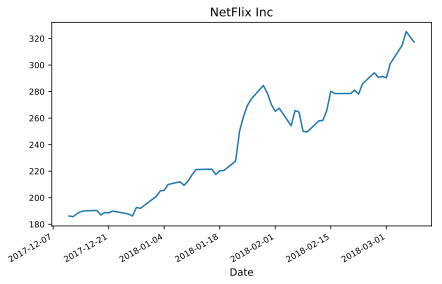

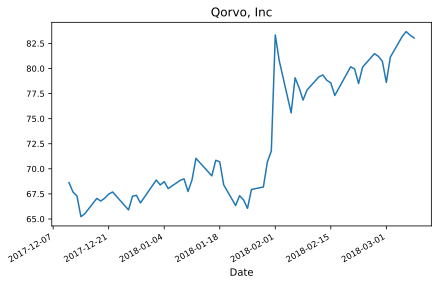

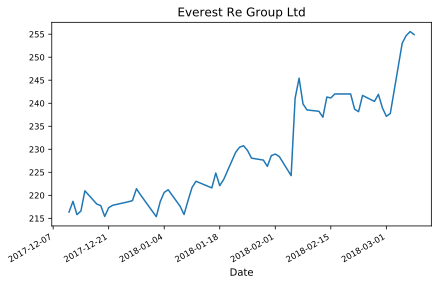

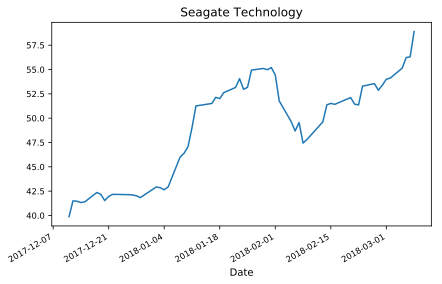

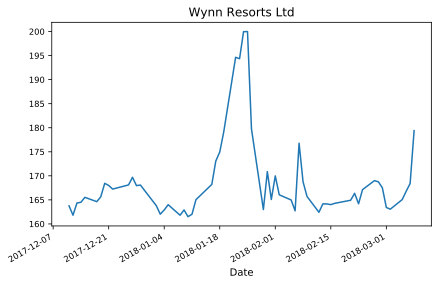

In [71]:
# plots all tickers to verify if there are any M&A targets
for t in recommend.sort_index().index:
    fig, ax = plt.subplots()
    plt.title(cos_no_dup.loc[t]['Company'])
    df_range = consol_px[t][-lb:]
    fig.tight_layout()
    df_range.plot(fontsize='small')
    plt.show()

In [72]:
sect_group_stats(recommend, 'Sector').sort_values(by='Sector Weight', ascending=False)

Total % Allocation 49.04


,Sector Weight,Avg Position
XLK,0.144398,0.028880
XLY,0.131269,0.043756
XLP,0.111378,0.037126
XLV,0.064962,0.032481
XLF,0.022357,0.022357
XLI,0.016087,0.016087


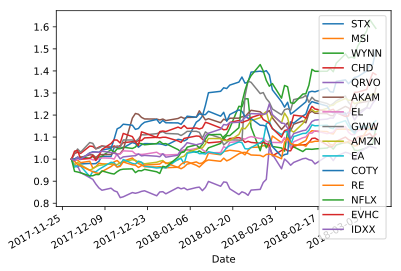

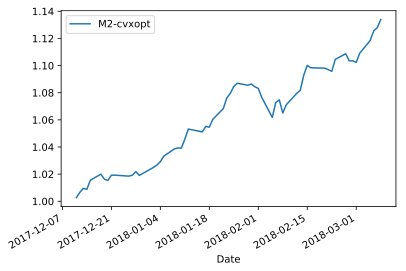

In [73]:
compound(consol_px[recommend.index][-hist_window:]).plot()
pdf.plot()

In [74]:
# Outputs for trade execution
px = consol_px[recommend.index][-lb:]
date = px[-1:].index.to_datetime().strftime(date_fmt)[0]
ret, risk = port_metrics(px_portion, rec)

trading_cols = ['Company', 'Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=rec.index, columns=trading_cols)

round_shares = lambda x: round(x, 0)
port_bal = 231000; alloc = rec.T.values
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
shares.apply(round_shares).T.sort_index()

trading_df['Company'] = recommend['Company']
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['Allocation']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print("Time Window: {}, Lookback: {}, MinGross: {}, MaxGross: {}, MinWeight: {}, MaxWeight: {}".format(hist_window, lb, min_gross, max_gross, min_w, max_w))
print("Ann. Ret: {0:.2f}, Risk: {1:.2f} Sharpe: {2:.2f}".format(ret, risk, ret / risk))
print("Date: {0}, Total Invested: {1:.2f}, Total Allocation: {2:.2f}%".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))
trading_df.head()
trading_df = trading_df.astype({'Dollar Value':np.int, 'Shares':np.int})
trading_df.sort_index()

Time Window: 100, Lookback: 60, MinGross: 0.5, MaxGross: 1, MinWeight: 0, MaxWeight: 0.05
Ann. Ret: 0.12, Risk: 0.04 Sharpe: 3.44
Date: 2018-03-08, Total Invested: 113293.91, Total Allocation: 49.04%


,Company,Price,Allocation,Dollar Value,Shares
AKAM,Akamai Technologies Inc,73.199997,0.021749,5023,68
AMZN,Amazon.com Inc,1549.349976,0.050000,11549,7
CHD,Church & Dwight Co,50.615002,0.029124,6727,132
COTY,Coty Inc.,19.330000,0.032254,7450,385
EA,Electronic Arts,128.500000,0.016590,3832,29
EL,Estee Lauder Cos. A,143.639999,0.050000,11549,80
EVHC,Envision Healthcare Corp,42.500000,0.050000,11549,271
GWW,Grainger W.W. Inc,272.000000,0.016087,3716,13
IDXX,IDEXX Laboratories Inc,197.130005,0.014962,3456,17
MSI,Motorola Solutions Inc,107.849998,0.036786,8497,78
